In [3]:
from h3 import h3
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import pandas as pd
from osgeo import gdal
from osgeo import osr
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
def imshow(image, show_axes = False, quiet = False):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image)
    if not show_axes:
        # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
        plt.axis('off')
    if not quiet:
        # Make sure it outputs
        plt.show()
        

In [31]:
outputfolder = '../_data/10_clean/05_for_viz'

# 1. Overall summary

In [6]:
cleanfolder1 = '../_data/10_clean/00_overallsummary'
# loading data from
individualfolder = '../_data/10_clean/03_individual/'
currentfolder = os.path.join(individualfolder, 'current/20230711d')
historicfolder = os.path.join(individualfolder, 'historical/20230711d')
currentfiles = os.listdir(currentfolder)
historicfiles = os.listdir(historicfolder)

selvideogroups = {
    '20100519-083343':"Chestnut Street", 
       '20100521-115755':"Downtown Crossing",
       '20100612-120118':"MET",
       '20081008-141944':"Bryant Park"}
# currentfiles

In [16]:
# set up condition
# only people with at least 1 full second appearance will be counted
# only people whose moving speed is below 2.5 m/s will be counted. Too fast indicates either not walking or not a person
# only consider people within the observation area
def conditiondata(df, fps):
    df = df[df['moving_speed'].isna()==False].reset_index(drop=True)
    df = df[df['moving_speed']<2.5].reset_index(drop=True)
    
    
    # df = df[df['individual_frame_total']>fps].reset_index(drop=True)
    df = df[df['inside']==True].reset_index(drop=True)
    df['emerging_group'] = np.where(df['group_track_delta']>fps*1, True, False)
    
    return df

def clean_data(df):
    df['group_size'] = df['cross_frame_group_id'].fillna("").apply(lambda x: len(x.split("&&")))
    
    df['stay'] = np.where(df['moving_speed'] < 0.5, True, False)
    if 'gender' not in df.columns:
        df['is_female'] = False
    else:
        df['is_female'] = np.where(df['gender']=='Female', True, False)
    df['is_group_loose'] = np.where(df['Social']!=-1, True, False)
    df = df.drop_duplicates(['track_id','frame_id']).reset_index(drop = True)
    
    df['group_size_combined'] = np.where(df['group_size']>5, 6, df['group_size'].astype(str))
    df['group_size_combined'] = df['group_size_combined'].astype(int)
    df['group_size_combined'] = np.where(df['group_size_combined']>5, "Over 5", 
                                                df['group_size_combined'].astype(str))
    
    return df
    

In [34]:
import gc
gc.collect()

0

In [9]:
# load data and consolidate column names
historicdf = []
for i in range(len(historicfiles)):
    if historicfiles[i].endswith('.csv'):
        historicdf.append(pd.read_csv(os.path.join(historicfolder, historicfiles[i])))
historicdf = pd.concat(historicdf).reset_index(drop = True)


currentvideodict = pd.DataFrame({
    "allfiles":currentfiles,
    "video_id":[x.split('.')[0] for x in currentfiles],
    'video_group':[x.split('b')[0] for x in currentfiles],
}
)
selcurrentfiles = currentvideodict[currentvideodict['video_group'].isin(selvideogroups.keys())]['allfiles'].tolist()
print(len(selcurrentfiles))
currentdf = []
for v in selcurrentfiles:
    currentdf.append(pd.read_csv(os.path.join(currentfolder, v)))
currentdf = pd.concat(currentdf).reset_index(drop = True)
currentdf.rename(columns = {'speed_0.5s':'moving_speed',
                            'speed_x_0.5s':'speed_x',
                            'speed_y_0.5s':'speed_y'}, inplace = True)
historicdf.rename(columns = {'speed_0.5s':'moving_speed',
                             'speed_x_0.5s':'speed_x',
                            'speed_y_0.5s':'speed_y'}, inplace = True)
historicdf['decades'] = '1980s'
currentdf['decades'] = '2010s'


currentdf['video_group'] = currentdf['video_id'].apply(lambda x: x.split('b')[0])
currentdf['video_location'] = currentdf['video_group'].apply(lambda x: selvideogroups[x])
currentdf['timestamp'] = pd.to_datetime(currentdf['timestamp'])


44


In [15]:
currentdf['moving_speed'] = currentdf.sort_values(['video_id', 'frame_id']).groupby(['video_id', 'track_id'])['moving_speed'].fillna(method='bfill')
currentdf[currentdf['moving_speed'].isna()].shape

(1109061, 30)

In [19]:
currentdf = conditiondata(currentdf, 29.97)
historicdf = conditiondata(historicdf, 48) # reprents one second

currentdf = clean_data(currentdf)
historicdf = clean_data(historicdf)

In [20]:
currentdf.shape

(7674354, 34)

In [21]:
# arrange the data at new frame id
historicdf['frame_indicator'] = historicdf['order']*100000000 + historicdf['frame_id']
orderdf = historicdf[["video_location",'frame_indicator']].drop_duplicates()\
.sort_values('frame_indicator').reset_index(drop = True).reset_index()
orderdf['frame_id_new'] = 1
orderdf['frame_id_new'] = orderdf.groupby('video_location')['frame_id_new'].transform(lambda x: x.cumsum())
historicdf = historicdf.merge(orderdf, on = ["video_location",'frame_indicator'], how = 'left')
historicdf['second_from_start'] = historicdf['frame_id_new']/48 # real second

In [22]:
current_summary = currentdf.groupby(['video_location','video_id']).agg(
    {
        'track_id':['nunique','count'],
        'frame_id':'nunique',
        'is_group':'sum',
        'is_group_loose':'sum',
        'stay':'sum',
        'is_female':'sum',
    }
).reset_index()
current_summary.columns = ['video_location','video_id','pedestrian_count_unique',
                           'pedestrian_count_total',
                           'frame_count',
                           'num_groups','num_groups_loose','num_stay','num_female']

current_summary = current_summary.groupby('video_location').agg(
    {
        'pedestrian_count_unique':'sum',
        'pedestrian_count_total':'sum',
        'frame_count':'sum',
        'num_groups':'sum',
        'num_groups_loose':'sum',
        'num_stay':'sum',
        'num_female':'sum'
    }
).reset_index()
current_summary['minutes'] = current_summary['frame_count']/29.97/60
current_summary['seconds'] = current_summary['frame_count']/29.97
current_summary['decades'] = '2010s'
current_summary['in_group_per'] = current_summary['num_groups']/current_summary['pedestrian_count_total']*100
current_summary['stay_per'] = current_summary['num_stay']/current_summary['pedestrian_count_total']*100
current_summary['women_per'] = current_summary['num_female']/current_summary['pedestrian_count_total']*100
current_summary['person_frame'] = current_summary['pedestrian_count_total']/current_summary['frame_count']
current_summary['in_group_loose_per'] = current_summary['num_groups_loose']/current_summary['pedestrian_count_total']*100
current_summary

,video_location,pedestrian_count_unique,pedestrian_count_total,frame_count,num_groups,num_groups_loose,num_stay,num_female,minutes,seconds,decades,in_group_per,stay_per,women_per,person_frame,in_group_loose_per
0,Bryant Park,23918,2625240,135794,1266408,1502975,853906,967229,75.516628,4530.997664,2010s,48.239704,32.526779,36.843451,19.332518,57.250956
1,Chestnut Street,11095,1221446,348001,312020,399378,265150,391072,193.527416,11611.644978,2010s,25.545133,21.707877,32.017134,3.509892,32.697147
2,Downtown Crossing,29617,1797840,122739,650427,1011568,360385,579690,68.256590,4095.395395,2010s,36.178247,20.045443,32.243692,14.647667,56.265741
3,MET,17160,2029828,61817,1485057,1581492,845516,0,34.377155,2062.629296,2010s,73.161716,41.654564,0.000000,32.836081,77.912611


In [23]:
historicalsummary = \
    historicdf.groupby(['video_location','video_id']).agg({
    'track_id':['nunique','count'],
        'frame_id':'nunique',
        'is_group':'sum',
        'is_group_loose':'sum',
        'stay':'sum',
}).reset_index()
historicalsummary.columns = ['video_location','video_id',
                             'pedestrian_count_unique','pedestrian_count_total',
                             'frame_count', 'num_groups',
                             'num_groups_loose','num_stay']
historicalsummary = historicalsummary.groupby('video_location').agg(
    {
        'pedestrian_count_unique':'sum',
        'pedestrian_count_total':'sum',
        'frame_count':'sum',
        'num_groups':'sum',
        'num_groups_loose':'sum',
        'num_stay':'sum',
    }
).reset_index()

historicalsummary['minutes'] = historicalsummary['frame_count']/479.79/60*10
historicalsummary['seconds'] = historicalsummary['frame_count']/479.79*10
historicalsummary['decades'] = '1980s'
historicalsummary['in_group_per'] = historicalsummary['num_groups']/historicalsummary['pedestrian_count_total']*100
historicalsummary['stay_per'] = historicalsummary['num_stay']/historicalsummary['pedestrian_count_total']*100
historicalsummary['person_frame'] = historicalsummary['pedestrian_count_total']/historicalsummary['frame_count']
historicalsummary['in_group_loose_per'] = historicalsummary['num_groups_loose']/historicalsummary['pedestrian_count_total']*100
historicalsummary

,video_location,pedestrian_count_unique,pedestrian_count_total,frame_count,num_groups,num_groups_loose,num_stay,minutes,seconds,decades,in_group_per,stay_per,person_frame,in_group_loose_per
0,Bryant Park,51842,2898435,290233,817377,1225994,977869,100.819456,6049.167344,1980s,28.200632,33.737827,9.986580,42.298482
1,Chestnut Street,6400,178662,88903,38602,63059,31147,30.882608,1852.956502,1980s,21.606161,17.433478,2.009628,35.295138
2,Downtown Crossing,26972,3097215,121949,1467726,1415623,1285221,42.361936,2541.716167,1980s,47.388573,41.496021,25.397625,45.706320
3,MET,30955,3207188,243126,1586368,1747916,1322324,84.455699,5067.341962,1980s,49.462894,41.230012,13.191465,54.499954


In [24]:

overallsummary = pd.concat([current_summary, historicalsummary]).reset_index(drop = True)
overallsummary.to_csv(os.path.join(cleanfolder1, 'overall_summary.csv'), index = False)

In [25]:
overallsummary.pivot(columns = ['decades',], values = ['in_group_per', 'in_group_loose_per', 'stay_per'], 
                     index = 'video_location')

in_group_per            in_group_loose_per             \
decades                  1980s      2010s              1980s      2010s   
video_location                                                            
Bryant Park          28.200632  48.239704          42.298482  57.250956   
Chestnut Street      21.606161  25.545133          35.295138  32.697147   
Downtown Crossing    47.388573  36.178247          45.706320  56.265741   
MET                  49.462894  73.161716          54.499954  77.912611   

                    stay_per             
decades                1980s      2010s  
video_location                           
Bryant Park        33.737827  32.526779  
Chestnut Street    17.433478  21.707877  
Downtown Crossing  41.496021  20.045443  
MET                41.230012  41.654564

In [269]:
overallsummary.pivot(columns = ['decades',], values = ['in_group_per', 'in_group_loose_per', 'stay_per'], 
                     index = 'video_location')

in_group_per            in_group_loose_per             \
decades                  1980s      2010s              1980s      2010s   
video_location                                                            
Bryant Park          25.128142  48.239704          38.612756  57.250956   
Chestnut Street      21.606161  25.545133          35.295138  32.697147   
Downtown Crossing    47.388573  36.178247          45.706320  56.265741   
MET                  49.462894  73.161716          54.499954  77.912611   

                    stay_per             
decades                1980s      2010s  
video_location                           
Bryant Park        33.114204  32.526779  
Chestnut Street    17.433478  21.707877  
Downtown Crossing  41.496021  20.045443  
MET                41.230012  41.654564

In [27]:
alldf = pd.concat([currentdf, historicdf]).reset_index(drop = True)

alldf['group_size'] = alldf['group_size'].fillna(1)
alldf['group_size_combined'] = np.where(alldf['group_size']>=4, 4, alldf['group_size'].astype(int))
alldf['group_size_combined'] = alldf['group_size_combined'].astype(int)
alldf['group_size_combined'] = np.where(alldf['group_size_combined']>=4, ">=4", 
                                     alldf['group_size_combined'].astype(str))

In [28]:
alldf.drop(['gender', 
            'age', 
            'timestamp',
            'is_female',
            'speed_x', 
            'speed_y',
            'inside',
            'order', 
            'frame_id_original',
            'appear_sec'], axis = 1, inplace = True)

In [33]:
import gc
gc.collect()

2663

In [32]:
alldf.to_csv(os.path.join(outputfolder, 'pedestrian_frame.csv'), index = False)

# 2. Time-series summary

In [166]:
cleanfolder1 = '../_data/10_clean/01_timeseries'
files = os.listdir(cleanfolder1)
df1 = pd.read_csv(os.path.join(cleanfolder1, 'pedestrian_per_min_2010s.csv')).drop('video_location', axis = 1)\
    .rename(columns = {'location_name':'video_location'})
df1['decades'] = 2010
df1 = df1[df1['video_group_update'].isin([
    'Chestnut20100519-083343', 
       'Downtown20100521-115755',
       'Met20100612-120118',
       'bryant_park20081008-141944'])]
df2 = pd.read_csv(os.path.join(cleanfolder1, 'pedestrian_per_min_1980s.csv'))
df2['decades'] = 1980

df_sum = pd.concat([df1, df2]).reset_index(drop = True)


In [167]:
color_dict = {'Bryant Park': '#f77189',
 'Chestnut Street': '#97a431',
 'Downtown Crossing': '#36ada4',
 'MET': '#a48cf4'}

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
graphicfolder = "../_graphics/viz"

In [169]:
df_sum.groupby(['decades','video_location']).size()

decades  video_location   
1980     Bryant Park          107
         Chestnut Street       43
         Downtown Crossing     43
         MET                   85
2010     Bryant Park           77
         Chestnut Street      202
         Downtown Crossing     63
         MET                   36
dtype: int64

/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/3960684080.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, "timeporal_pedestrian_count.png"), index = False, dpi = 200)


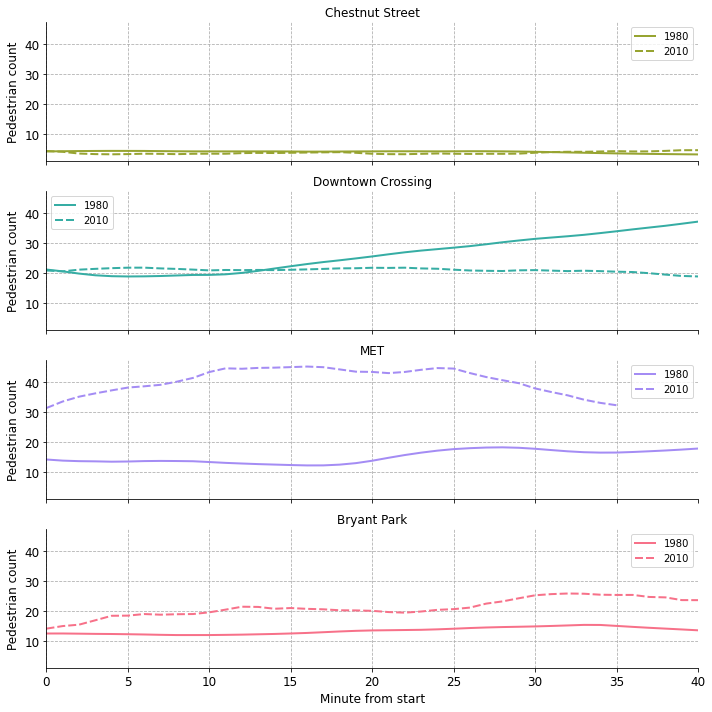

In [249]:
# plot one location one plot
import matplotlib.pyplot as plt
import seaborn as sns
graphicfolder = "../_graphics/viz"
fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True, sharey=True)
for i, loc in enumerate(df_sum['video_location'].unique()):
    temp = df_sum[df_sum['video_location'] == loc]
    sns.lineplot(data = temp,
                 x="minute_from_start", 
             y=f"pedestrian_count_rolling_10m", 
             color = color_dict[loc],
             style = 'decades',
             ci = None,
             linewidth=2, 
             ax = axes[i])
    axes[i].set_title(loc)
    axes[i].set_xlabel('Minute from start', fontsize = 12)
    axes[i].set_ylabel('Pedestrian count', fontsize = 12)
    # set up tick size
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend(['1980', '2010'])
    # set x limit
    axes[i].set_xlim([0, 40])
    sns.despine()
    # show major grids
    axes[i].grid(which='major', axis='both', linestyle='--')
plt.tight_layout()
fig.savefig(os.path.join(graphicfolder, "timeporal_pedestrian_count.png"), index = False, dpi = 200)

# 3. Spatial Summary

In [133]:
h3_clean = "../_data/10_clean/02_h3_agg"

agg1 = gpd.read_file(os.path.join(h3_clean, f"1980s_h3_agg.geojson"))
agg1['decades'] = '1980s'
agg2 = gpd.read_file(os.path.join(h3_clean, f"2010s_h3_agg.geojson"))
agg2['decades'] = '2010s'
sp_sum = pd.concat([agg1, agg2]).reset_index(drop = True)
sp_sum.head()

,hex_id,video_location,index_right,location_name,pedestrian_count_sum,frame_count,pedestrian_count_frame,pedestrian_unique_count,total_second,geometry,decades
0,8f2a100890aa143,MET,0,MET,427.0,24314,0.017562,178.0,5070.0,"POLYGON ((-73.96232 40.77926, -73.96233 40.779...",1980s
1,8f2a100890aa3a6,MET,0,MET,152.0,24314,0.006252,67.0,5070.0,"POLYGON ((-73.96238 40.77918, -73.96239 40.779...",1980s
2,8f2a100890aa04d,MET,0,MET,1373.0,24314,0.056470,452.0,5070.0,"POLYGON ((-73.96234 40.77919, -73.96234 40.779...",1980s
3,8f2a100890aa3ad,MET,0,MET,2703.0,24314,0.111171,565.0,5070.0,"POLYGON ((-73.96236 40.77915, -73.96236 40.779...",1980s
4,8f2a100890aa721,MET,0,MET,30.0,24314,0.001234,26.0,5070.0,"POLYGON ((-73.96250 40.77922, -73.96251 40.779...",1980s


In [131]:
aggstep1 = alldf.groupby(['hex_id','decades','video_id','frame_id']).agg({
    'track_id':'nunique',
    'is_group':'sum',
    'emerging_group':'sum',
    'stay':'sum',
    'moving_speed':'mean',
}).reset_index()
samplestep1 = aggstep1[aggstep1['frame_id']%30==0].reset_index(drop = True)

viz = sp_sum[['hex_id','decades','video_location']].drop_duplicates().merge(samplestep1, on = ['hex_id','decades'], how = 'left')
fillna_cols = ['track_id','is_group','emerging_group','stay']
for col in fillna_cols:
    viz[col] = viz[col].fillna(0)
viz.rename(columns = {'track_id':'pedestrian_count','is_group':'group_count','emerging_group':'emerging_group_count','stay':'stay_count'}, 
           inplace = True)

viz2 = viz.groupby(['hex_id','decades']).agg({
    'pedestrian_count':'mean',
    'group_count':'mean',
    'emerging_group_count':'mean',
    'stay_count':'mean',
    'moving_speed':'mean',
}).reset_index()
vizupdate = sp_sum[['hex_id','video_location','geometry','decades']].drop_duplicates().merge(viz2, on = ['hex_id', 'decades'], how = 'left')
vizupdate['stay_per'] = vizupdate['stay_count']/vizupdate['pedestrian_count']*100
vizupdate['group_per'] = vizupdate['group_count']/vizupdate['pedestrian_count']*100

namematching = {
    'chestnutstreet':"Chestnut Street", 
       'downtowncrossing':"Downtown Crossing",
       'MET':"MET",
       'bryant_park1':"Bryant Park"}
vizupdate['video_location'] = vizupdate['video_location'].apply(lambda x: namematching[x])


In [129]:
# vizupdate.to_file(os.path.join('/Users/yuan/Dropbox (MIT)/whyte_CV/_data/10_clean/05_use_this', 'h3_agg.geojson'), driver='GeoJSON')

/Users/yuan/opt/anaconda3/envs/geo38/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
# sp_sum['pedestrian_unique_count_second'] = sp_sum['pedestrian_unique_count']/sp_sum['total_second']

<AxesSubplot:xlabel='pedestrian_count', ylabel='Density'>

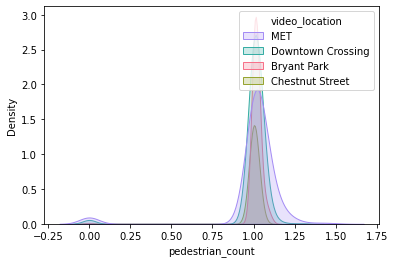

In [130]:
# plot a histogram by location
sns.kdeplot(data = vizupdate[vizupdate['decades'] == '1980s'], 
            x = 'pedestrian_count', 
            hue = 'video_location', 
            fill = True, 
            palette=color_dict)

<AxesSubplot:xlabel='pedestrian_count', ylabel='Density'>

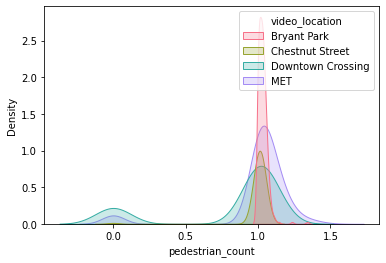

In [132]:
sns.kdeplot(data = vizupdate[vizupdate['decades'] == '2010s'], 
            x = 'pedestrian_count', 
            hue = 'video_location', 
            fill = True, 
            palette=color_dict)

In [101]:
schema = {
    'hex_id':"h3 index at level 15, 15 is the most detailed level, 0 is the most general level, estimated area: 0.895 sqm", 
    'video_location':'Location name',
       'pedestrian_count':"Aerage pedestrian count per frame", 
       "group_count":"Average count of people in a group per frame",
       "emerging_group_count":"Averge count of peopple in an emerging group per frame",
       "stay_count":"Average count of people stay (speed<0.5) per frame",
       "moving_speed":"Average moving speed per frame",
       "stay_per":"% of people stay (speed<0.5) per frame",
       "group_per":"% of people in a group per frame",
       "decades":"either 1980s or 2010s",
    #    'frame_count':"total number of frames calculated, in 1980, frame rate is 4.98, in 2010 frame rate is 29.97",
    #    'pedestrian_count_frame':"Average Pedestian count per frame",
    #    'pedestrian_unique_count':"Total unique pedestrian (consider each pedestrian as unique, pedestrian will be counted only once)", 
    #    'total_second':"Total second of the video",
    #    'geometry':"h3 geometry", 
    #    'year_group':'year group',
    #    'pedestrian_unique_count_second':"unique number of pedestrian per second"
}
# sp_sum[list(schema.keys())].drop("geometry", axis = 1).to_csv(os.path.join(h3_clean, "h3_summary.csv"), index = False)
# sp_sum[list(schema.keys())].to_file(os.path.join(h3_clean, "h3_summary.geojson"), driver='GeoJSON')
# save the schema as a json file
import json
schemafolder = "/Users/yuan/Dropbox (MIT)/whyte_CV/_data/10_clean/05_use_this/_schema"
json.dump(schema, open(os.path.join(schemafolder, "h3_summary_schema.json"), 'w'))

In [136]:
# create a wide table
sp_sum['pedestrian_unique_count_second'] = sp_sum['pedestrian_unique_count']/sp_sum['total_second']
y = 'pedestrian_unique_count_second'
# y = 'pedestrian_count_frame'
sp_sum_wide = sp_sum.pivot(index = ['hex_id', 'location_name'], 
                           columns = 'decades', 
                           values = y).reset_index()\
                               .rename(columns = {'1980s':'ped_count_1980', '2010s':'ped_count_2010'}).fillna(0)
sp_sum_wide['log_ped_count_1980'] = np.log(sp_sum_wide['ped_count_1980']+1)
sp_sum_wide['log_ped_count_2010'] = np.log(sp_sum_wide['ped_count_2010']+1)
sp_sum_wide.head()


decades,hex_id,location_name,ped_count_1980,ped_count_2010,log_ped_count_1980,log_ped_count_2010
0,8f2a100890aa000,MET,0.035306,0.011369,0.034697,0.011305
1,8f2a100890aa001,MET,0.043984,0.051161,0.043044,0.049895
2,8f2a100890aa002,MET,0.021105,0.007106,0.020885,0.007081
3,8f2a100890aa003,MET,0.031755,0.038370,0.031262,0.037653
4,8f2a100890aa004,MET,0.030375,0.018475,0.029923,0.018306


In [137]:
sp_sum_wide.to_csv(os.path.join(h3_clean, "h3_summary_wide.csv"), index = False)

In [138]:
# get correlation and p-value, ignore nan
from scipy.stats import pearsonr
result = []
for loc in sp_sum_wide['location_name'].unique():
    temp = sp_sum_wide[sp_sum_wide['location_name'] == loc]
    corr = pearsonr(temp['log_ped_count_1980'], temp['log_ped_count_2010'] 
                    )
    result.append([loc, corr[0], corr[1]])
result = pd.DataFrame(result, columns = ['location_name', 'corr', 'p_value'])
result

,location_name,corr,p_value
0,MET,0.085498,5.631647e-02
1,Bryant Park,0.681636,1.655755e-38
2,Chestnut Street,0.437789,1.522676e-08
3,Downtown Crossing,0.092202,5.410075e-02


# 4. Overall Speed Summary

In [217]:
individualdf_moving = alldf[alldf['moving_speed']>0.5]\
    .groupby(['video_location', 'video_id', 'track_id', 
              'decades',
              'group_size_combined','is_group']).agg({
    "moving_speed":'mean',
}).reset_index() # walking people only

In [218]:
individualdf_all = alldf.groupby(['video_location', 'video_id', 'track_id', 'decades','group_size_combined','is_group']).agg({
    "moving_speed":'mean',
}).reset_index() # all people

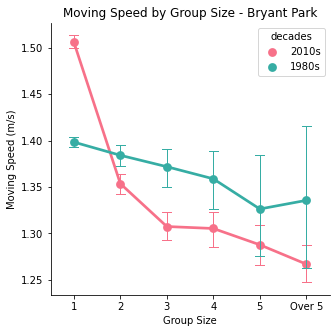

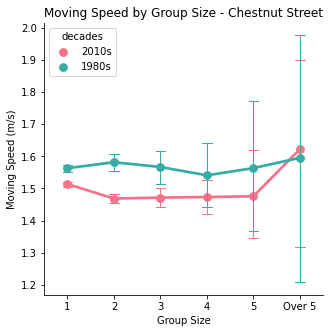

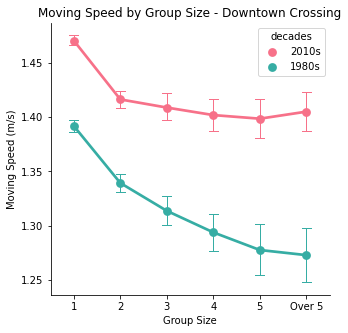

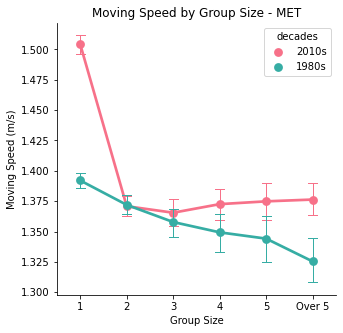

In [223]:
import seaborn as sns
from matplotlib import pyplot as plt
for loc in alldf['video_location'].unique():
    fig, ax = plt.subplots(figsize = (5,5))
    temp = individualdf_moving[individualdf_moving['video_location'] == loc]
    sns.pointplot(
        data = temp[temp['moving_speed']<2.5],
        x = "group_size_combined",
        y = 'moving_speed',
        ci = 98,
        errwidth = 1,
        capsize=.2,
        hue = 'decades',
        palette = ['#f77189', '#36ada4'],
        # set x order
        order=['1','2','3','4','5','Over 5']
 

)

    ax.set_title(f"Moving Speed by Group Size - {loc}")
    ax.set_ylabel("Moving Speed (m/s)")
    ax.set_xlabel("Group Size")
    sns.despine()

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    fig.savefig(os.path.join(graphicfolder, 
                             f"moving_speed_group_size_{loc}.png"),  
                dpi = 300)

In [224]:
# conduct t-test between 1980 and 2010 for each location: walking people only
from scipy.stats import ttest_ind
result = []
for loc in alldf['video_location'].unique():
    temp = individualdf_moving[(individualdf_moving['video_location'] == loc)]
    ttest = ttest_ind(temp[temp['decades'] == '1980s']['moving_speed'], 
                      temp[temp['decades'] == '2010s']['moving_speed'])
    mean_value = temp.groupby('decades')['moving_speed'].mean().reset_index()['moving_speed'].tolist()
    result.append([loc, ttest[0], ttest[1], mean_value[0], mean_value[1], mean_value[1]-mean_value[0]])
result = pd.DataFrame(result, columns = ['location_name', 't_stat', 'p_value', 'mean_1980', 'mean_2010', 'diff'])
result.to_csv(os.path.join(cleanfolder1, "ttest_moving_speed.csv"), index = False)
result

,location_name,t_stat,p_value,mean_1980,mean_2010,diff
0,Bryant Park,-6.261313,3.839447e-10,1.392781,1.412349,0.019568
1,Chestnut Street,11.559451,8.267706e-31,1.566036,1.504928,-0.061108
2,Downtown Crossing,-36.778974,1.195114e-293,1.360889,1.447390,0.086501
3,MET,-18.779903,1.642963e-78,1.374661,1.424473,0.049812


/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/881619134.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"all_speed_distribution_{loc}.png"), index = False, dpi = 300)
/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/881619134.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"all_speed_distribution_{loc}.png"), index = False, dpi = 300)
/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/881619134.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"all_speed_distribution_{loc}.png"), index = Fals

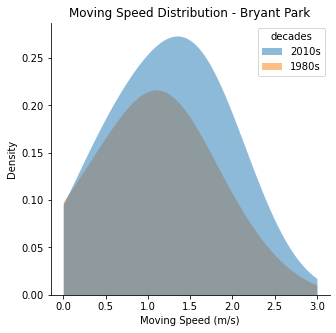

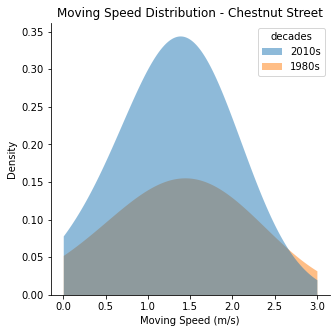

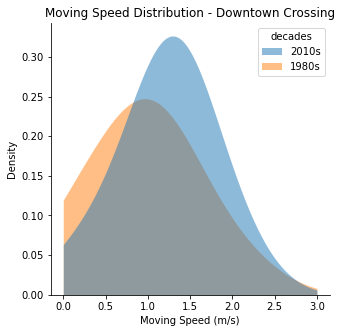

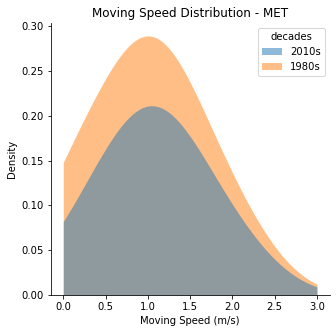

In [221]:
for loc in alldf['video_location'].unique():
    fig, ax = plt.subplots(figsize = (5,5))
    temp = individualdf_all[individualdf_all['video_location'] == loc]
    sns.kdeplot(data = temp, 
                    x = f'moving_speed',
                    ax = ax,
                    clip = (0, 3),
                    fill=True,
                    # color = colorset[location],
                    hue = 'decades',
                    linewidth=0,
                    alpha = 0.5,
                    bw_adjust=7,
                    )
    ax.set_title(f"Moving Speed Distribution - {loc}")
    ax.set_xlabel("Moving Speed (m/s)")
    sns.despine()

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    fig.savefig(os.path.join(graphicfolder, f"all_speed_distribution_{loc}.png"), index = False, dpi = 300)

# 5. Emerging Groups

In [253]:
# plot group size combined distribution
alldf_sampled = alldf[alldf['frame_id']%30==0].reset_index(drop = True)

groupsize_summary = alldf_sampled[alldf_sampled['is_group']==True].groupby(['group_size_combined', 
                                                                            'decades',
                                                                            'video_id',
                                                                            'video_location']).agg({
    'group_id_social':'nunique',
    # 'frame_id':'nunique',
    'track_id':'nunique'
}).reset_index().rename(columns = {'group_id_social':'group_count',
                                #    'frame_id':'frame_count',
                                   'track_id':'person_in_group'})\
    .groupby(['video_location','group_size_combined', 'decades']).agg({
        'group_count':'sum',
        # 'frame_count':'sum',
        'person_in_group':'sum',
    }).reset_index()
    
overall_summary = alldf_sampled.groupby(['decades','video_id','video_location']).agg({
    'frame_id':'nunique',
    'track_id':'nunique'
}).reset_index().rename(columns = {
                                   'frame_id':'frame_count',
                                   'track_id':'person'})\
    .groupby(['video_location', 'decades']).agg({
        'frame_count':'sum',
        'person':'sum',
    }).reset_index()
    
groupsize = groupsize_summary.merge(overall_summary, on = ['video_location', 'decades'], how = 'left')

groupsize['person_in_group_per'] = groupsize['person_in_group']/groupsize['person']*100
groupsize

,video_location,group_size_combined,decades,group_count,person_in_group,frame_count,person,person_in_group_per
0,Bryant Park,2,1980s,5139,4247,5912,23744,17.886624
1,Bryant Park,2,2010s,14444,6247,4524,19729,31.664048
2,Bryant Park,3,1980s,1188,1194,5912,23744,5.028639
3,Bryant Park,3,2010s,3836,2973,4524,19729,15.069187
4,Bryant Park,4,1980s,331,422,5912,23744,1.777291
5,Bryant Park,4,2010s,1749,1928,4524,19729,9.772416
6,Bryant Park,5,1980s,72,141,5912,23744,0.593834
7,Bryant Park,5,2010s,803,1142,4524,19729,5.788433
8,Bryant Park,Over 5,1980s,34,66,5912,23744,0.277965
9,Bryant Park,Over 5,2010s,974,1629,4524,19729,8.256881


/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/3684849354.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"group_size_distribution_{loc}.png"), index = False, dpi = 300)
/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/3684849354.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"group_size_distribution_{loc}.png"), index = False, dpi = 300)
/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_1774/3684849354.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"group_size_distribution_{loc}.png"), index 

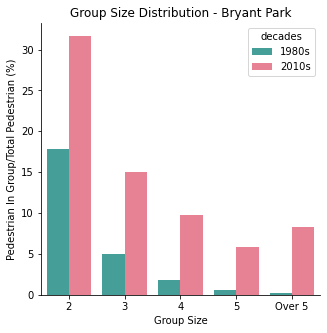

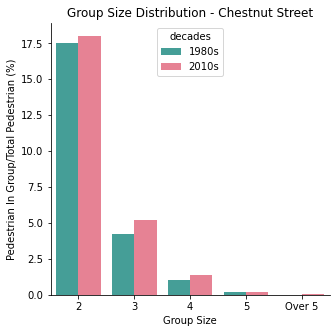

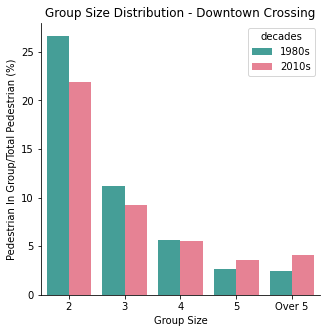

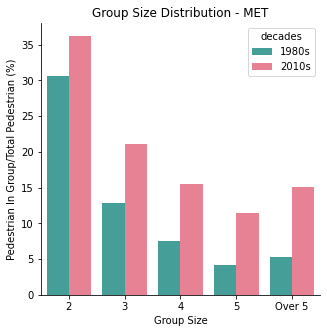

In [255]:
# plot group size combined distribution
# Change to percentage
for loc in alldf['video_location'].unique():
    temp = groupsize[groupsize['video_location'] == loc]
    fig, ax = plt.subplots(figsize = (5,5))
    sns.barplot(data = temp,
                x = 'group_size_combined',
                y = 'person_in_group_per',
                hue = 'decades',
                # revser the color order
                palette=[ '#36ada4','#f77189'],
                order=['2','3','4','5','Over 5'],
                ax = ax
                )
    ax.set_title(f"Group Size Distribution - {loc}")
    ax.set_xlabel("Group Size")
    ax.set_ylabel("Pedestrian In Group/Total Pedestrian (%)")
    sns.despine()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    fig.savefig(os.path.join(graphicfolder, f"group_size_distribution_{loc}.png"), index = False, dpi = 300)



In [283]:
groupdf = alldf[alldf['is_group']==True].reset_index(drop = True)
group_sum = groupdf.groupby(['video_location', 'video_id', 'decades','frame_id']).agg({
    'emerging_group':'sum',
    'stay':'sum',
    'track_id':'count'
}).reset_index().rename(columns = {'track_id':'num_pedestrian'})
group_sum_2 = group_sum.groupby(['video_location', 'decades']).agg({
    'emerging_group':'sum',
    'stay':'sum',
    'num_pedestrian':'sum'

}).reset_index()

In [284]:
group_sum_2['emerging_per'] = group_sum_2['emerging_group']/group_sum_2['num_pedestrian']*100
group_sum_2['stay_per'] = group_sum_2['stay']/group_sum_2['num_pedestrian']*100
group_sum_2.pivot(columns = 'decades', 
                  values = 'emerging_per', 
                  index = 'video_location')

decades,1980s,2010s
video_location,,
Bryant Park,11.758622,20.821963
Chestnut Street,5.481581,31.826165
Downtown Crossing,15.109019,17.234217
MET,12.323181,15.105750


In [285]:
group_sum_2.pivot(columns = 'decades', values = 'stay_per', index = 'video_location')

decades,1980s,2010s
video_location,,
Bryant Park,37.797373,37.481602
Chestnut Street,18.276255,22.552080
Downtown Crossing,45.299531,21.355510
MET,42.980632,45.194562


In [235]:
# merge to frame_id space
# each frame to get 
# number of groups, number of emerging groups, number of stay groups, number of total pedestrian\
    # average moving speed, total number of people staying
framedf = alldf.groupby(['video_location', 'video_id', 'decades','frame_id']).agg({
    'track_id':'nunique',
    'is_group':'sum',
    'emerging_group':'sum',
    'stay':'sum',
    'moving_speed':'mean',
}).reset_index().rename(columns = {'track_id':'num_pedestrian',
                                   'is_group':'num_pedestrian_in_groups',
                                   'stay':'num_stay',
})
framedf.head()

,video_location,video_id,decades,frame_id,num_pedestrian,num_pedestrian_in_groups,emerging_group,num_stay,moving_speed
0,Bryant Park,20081008-141944b01,2010s,1,4,2,0,1,1.190382
1,Bryant Park,20081008-141944b01,2010s,2,4,2,0,1,1.190382
2,Bryant Park,20081008-141944b01,2010s,3,2,0,0,0,1.878518
3,Bryant Park,20081008-141944b01,2010s,4,3,2,0,1,0.831646
4,Bryant Park,20081008-141944b01,2010s,5,2,1,0,0,1.071683


In [236]:
# sample every 30 frames per video
framedf = framedf[framedf['frame_id']%30==0].reset_index(drop = True)
framedf['stay_per'] = framedf['num_stay']/framedf['num_pedestrian']*100
framedf['group_per'] = framedf['num_pedestrian_in_groups']/framedf['num_pedestrian']*100

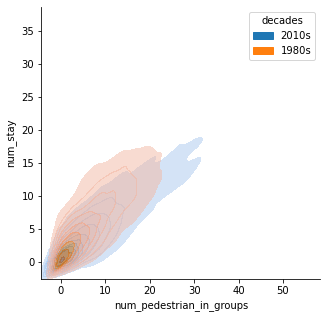

In [237]:
figsize = (5,5)
import seaborn as sns
fig, ax = plt.subplots(figsize = figsize)
sns.kdeplot(
                data = framedf,
                x = 'num_pedestrian_in_groups',
                y = 'num_stay',
                hue = 'decades',
                fill=True,
                alpha = 0.5,
)
sns.despine()


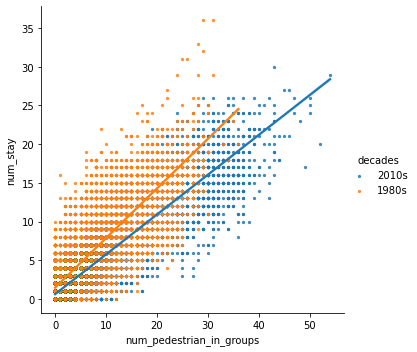

In [238]:

sns.lmplot(
                data = framedf,
                x = 'num_pedestrian_in_groups',
                y = 'num_stay',
                hue = 'decades',
                ci = 95,
                scatter_kws={"s": 5},
                
)

sns.despine()

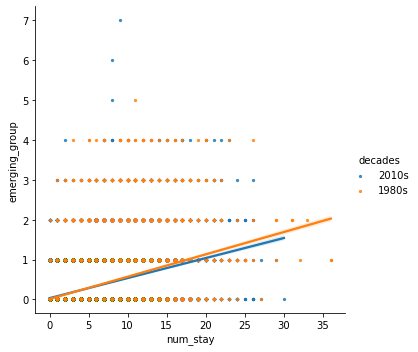

In [239]:
sns.lmplot(
                data = framedf,
                x = 'num_stay',
                y = 'emerging_group',
                hue = 'decades',
                ci = 95,
                scatter_kws={"s": 5},
                
)

sns.despine()

In [240]:
framefolder = "/Users/yuan/Dropbox (MIT)/whyte_CV/_data/10_clean/04_frame_agg"
framedf.to_csv(os.path.join(framefolder, "frame_agg.csv"), index = False)

# H3 level aggregation of group observations

In [241]:
h3df = alldf.groupby(['video_location', 'video_id', 'decades','frame_id','hex_id']).agg({
    'track_id':'nunique',
    'is_group':'sum',
    'emerging_group':'sum',
    'stay':'sum',
    'moving_speed':'mean',
}).reset_index().rename(columns = {'track_id':'num_pedestrian',
                                   'is_group':'num_pedestrian_in_groups',
                                   'stay':'num_stay',
}).groupby(['video_location', 'video_id', 'decades','hex_id']).agg({
    "num_pedestrian":'sum',
    "frame_id":'nunique',
    "emerging_group":'sum',
    "num_stay":"sum",
    'num_pedestrian_in_groups':"sum"
}).reset_index()
h3df['ped_frame']= h3df['num_pedestrian']/h3df['frame_id']
h3df['emerging_per'] = h3df['emerging_group']/h3df['num_pedestrian']*100
# h3df['emerging_per'] = h3df['emerging_group']/h3df['num_pedestrian_in_groups']*100
h3df['group_frame'] = h3df['num_pedestrian_in_groups']/h3df['frame_id']
h3df['stay_per'] = h3df['num_stay']/h3df['num_pedestrian']*100


In [242]:
h3df['emerging_per'] = h3df['emerging_group']/h3df['num_pedestrian']*100

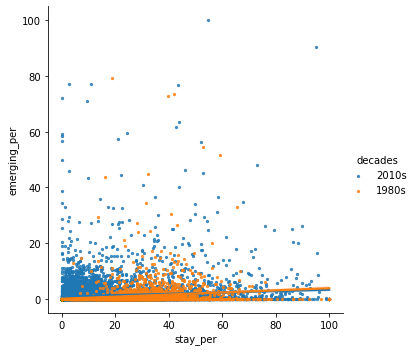

In [243]:
sns.lmplot(
                data = h3df,
                x = 'stay_per',
                y = 'emerging_per',
                hue = 'decades',
                ci = 95,
                scatter_kws={"s": 5},

)

sns.despine()

In [244]:
h3df.to_csv(os.path.join(framefolder, "h3_agg.csv"), index = False)

In [39]:
metadata = {
    'order':"video order in one location", 
     'video_location':"video location name", 
     'track_id':"reconstructed track id, unique within each video", 
       'video_id':"video id, unique within each location",
       'lat':"prejected latitude",
       'lon':"prejected longitude",
       'track_id_backup':"original track id from the tracking file", 
       'move_speed':"speed in meter per second",
       'hex_id':"h3 level 15 index", 
      #  'inside':"inside the comparable area (both historical and current) or not",
        'frame_id':"reconstructed frame_id, across videos in a location, unique within one location", 
        # 'frame_id_original':"original frame_id from the tracking file", 
        'second_from_start':"calculated second from start based on the frame_id, 48 frames per real second",
      #  'appear_sec':"total second the track appeared in the video", 
       'individual_frame_total':"total number of frames the track appeared in the video", 
      #  'Social':"spatial cluster id, unique within each frame, disregarding invalid or valid across time", 
       'frame_social_track':"frame_id + Social + track_id",
       'group_id_social':"frame_id + Social, unique within each video",
       'group_size':"number of tracks in the group",
       'is_group':"whether the track is in a group or not",
       'group_first_frame':"first frame_id when the track is in a group",
       'track_first_frame':"first frame_id when the track appear in this video", 
       'group_track_delta':"difference between group_first_frame and track_first_frame", 
       'emerging_group':"whether the group is newly formed or not",
       "group_size_combined":"grouping the group size into buckets",
       'cross_frame_group_id': "this is a group id that can be used to identify the group across frames (only available for current videos)",
         "gender":"gender of each pedestrian",
         "age":"age of each pedestrian",
         'timestamp':"timestamp of each frame (Only available for modern videos). use for reference.",
         "is_group_loose":"if the group only satisfy the spatial constriants"
}
import json
with open(os.path.join(outputfolder, "pedestrian_frame_meta.json"), "w") as the_file:
  json.dump(metadata, the_file, indent=4)